In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pmdarima as pm

In [7]:
np.random.seed(24)
plt.style.use('fivethirtyeight')

In [8]:
co = pd.read_csv("co2.csv", parse_dates=["date"], index_col="date")
co.head()

,CO2_ppm
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [9]:
co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 727 entries, 1958-03-01 to 2018-09-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CO2_ppm  727 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


#### Visualizing the time-series

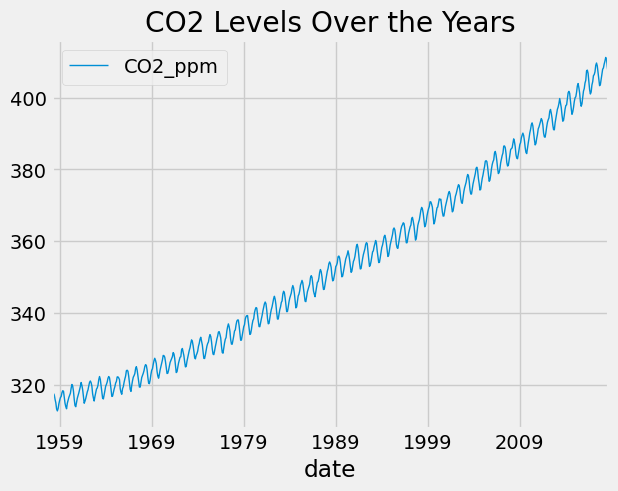

In [10]:
co.plot(title="CO2 Levels Over the Years", linewidth=1)
plt.show()

In [11]:
co['roll_mean'] = co["CO2_ppm"].rolling(12).mean()
co['roll_std'] = co["CO2_ppm"].rolling(12).std()

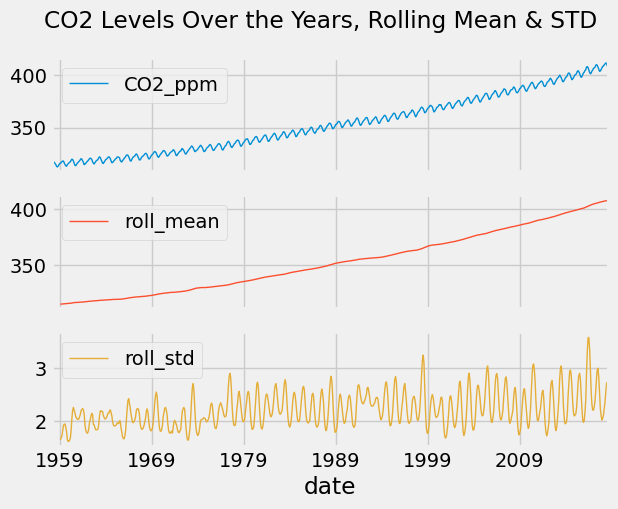

In [12]:
co.plot(title="CO2 Levels Over the Years, Rolling Mean & STD", linewidth=1, subplots=True)
plt.show()

In [13]:
def check_stationarity(dataset, col):
    res = "Non Stationary"
    adf = adfuller(dataset[col])
    if adf[1] < 0.05:
        res = "Stationary"
    return res + ", p-val: " + str(adf[1])
        

In [14]:
check_stationarity(co, 'CO2_ppm')

'Non Stationary, p-val: 1.0'

In [15]:
adfuller(co['CO2_ppm'])

(4.774866785205458,
 1.0,
 20,
 706,
 {'1%': -3.439646367660705,
  '5%': -2.8656425177031375,
  '10%': -2.5689546724554404},
 494.90714335429107)

In [16]:
co['log'] = np.log(co['CO2_ppm'])
co['diff'] = co['CO2_ppm'].diff(1).fillna(0)
co.head(10)

,CO2_ppm,roll_mean,roll_std,log,diff
date,,,,,
1958-03-01,315.71,NaN,NaN,5.754824,0.00
1958-04-01,317.45,NaN,NaN,5.760320,1.74
1958-05-01,317.50,NaN,NaN,5.760478,0.05
1958-06-01,317.10,NaN,NaN,5.759217,-0.40
1958-07-01,315.86,NaN,NaN,5.755299,-1.24
1958-08-01,314.93,NaN,NaN,5.752350,-0.93
1958-09-01,313.20,NaN,NaN,5.746842,-1.73
1958-10-01,312.66,NaN,NaN,5.745116,-0.54
1958-11-01,313.33,NaN,NaN,5.747257,0.67


In [17]:
check_stationarity(co, 'diff')

'Stationary, p-val: 6.720287998347345e-06'

In [18]:
co2 = co[['CO2_ppm']].copy(deep=True)
co2.head()

,CO2_ppm
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [19]:
co2['diff1'] = co2['CO2_ppm'].diff(1)
co2['diff12'] = co2['CO2_ppm'].diff(12)

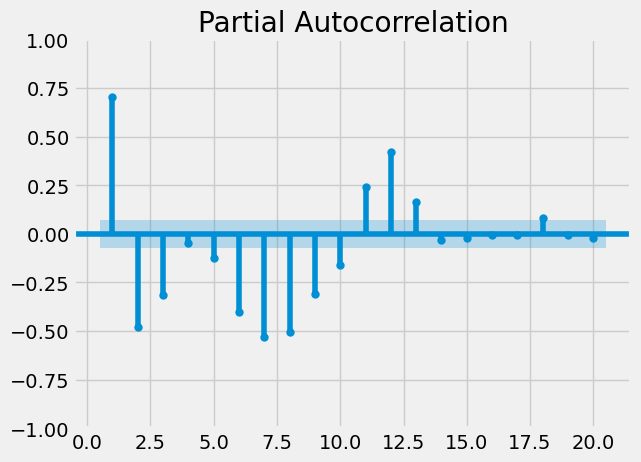

In [20]:
plot_pacf(co2['diff1'].dropna(), lags=20, zero=False);

In [21]:
posp = [1, 2, 3]

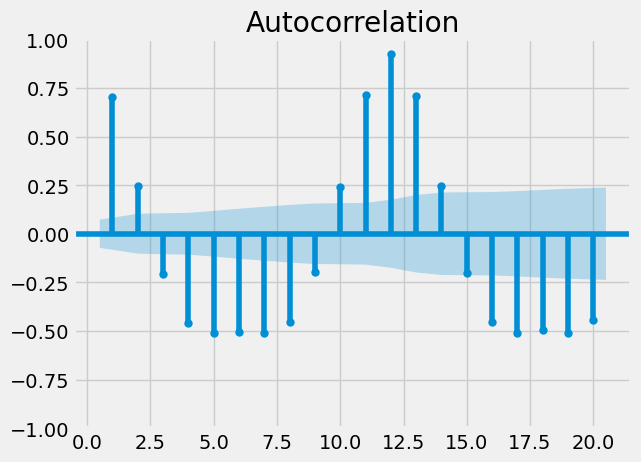

In [22]:
plot_acf(co2['diff1'].dropna(), lags=20, zero=False);

In [23]:
posq = [8, 9]

In [24]:
train = co2[:508]
test = co2[508:]

In [25]:
for p in posp:
    for q in posq:
        model = ARIMA(train[['CO2_ppm']], order=(p, 1, q))
        fitted = model.fit()
        print(f"p:{p}, q:{q}, aic:{fitted.aic}")

p:1, q:8, aic:982.9635299337936
p:1, q:9, aic:970.1545402191206
p:2, q:8, aic:693.5033701278935
p:2, q:9, aic:697.8466667597829
p:3, q:8, aic:740.7804497140035
p:3, q:9, aic:685.4588325428322


In [26]:
best = ARIMA(train[['CO2_ppm']], order=(3,1,9))
fitted = best.fit()
predictions = fitted.predict(start=test.index[0], end=test.index[-1])

In [27]:
co2['arimapred'] = predictions

In [28]:
co2.tail()

,CO2_ppm,diff1,diff12,arimapred
date,,,,
2018-05-01,411.24,1.00,1.55,372.012914
2018-06-01,410.79,-0.45,1.91,371.210116
2018-07-01,408.71,-2.08,1.59,370.160453
2018-08-01,406.99,-1.72,1.86,369.146208
2018-09-01,405.51,-1.48,2.14,368.439499


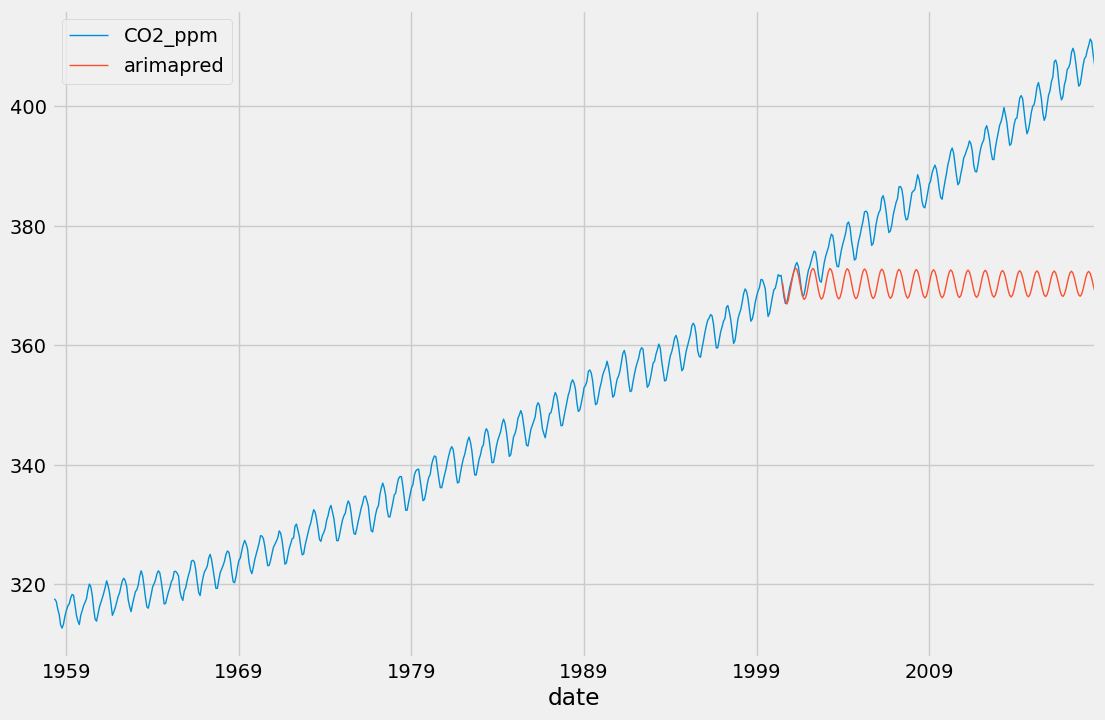

In [29]:
ax = co2['CO2_ppm'].plot(linewidth=1, figsize=(12,8))
co2['arimapred'].plot(linewidth=1, ax=ax)
plt.legend()
plt.show()

In [30]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CO2_ppm   No. Observations:                  508
Model:                 ARIMA(3, 1, 9)   Log Likelihood                -329.729
Date:                Tue, 07 Jan 2025   AIC                            685.459
Time:                        19:55:15   BIC                            740.429
Sample:                    03-01-1958   HQIC                           707.016
                         - 06-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7922      0.122      6.520      0.000       0.554       1.030
ar.L2          0.6228      0.210      2.964      0.003       0.211       1.035
ar.L3         -0.9349      0.121     -7.712      0.000      -1.172      -0.697
ma.L1         -0.6845      0.123     -5.550      0.000      -0.926      -0.443
ma.L2         -0.9576      0.203     -4.716      0.000      -1.356      -0.560
ma.L3          0.6566      0.099      6.613      0.000       0.462       0.851
ma.L4          0.4343      0.066      6.563      0.000       0.305       0.564
ma.L5          0.5128      0.073      7.024      0.000       0.370       0.656
ma.L6         -0.3059      0.068     -4.515      0.000      -0.439      -0.173
ma.L7         -0.6590      0.096     -6.829      0.000      -0.848      -0.470
ma.L8          0.1630      0.049      3.328      0.001       0.067       0.259
ma.L9          0.3618      0.056      6.484      0.000       0.252       0.471
sigma2         0.2089      0.015     14.066      0.000       0.180       0.238
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.18   Prob(JB):                         0.29
Heteroskedasticity (H):               1.13   Skew:                            -0.04
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

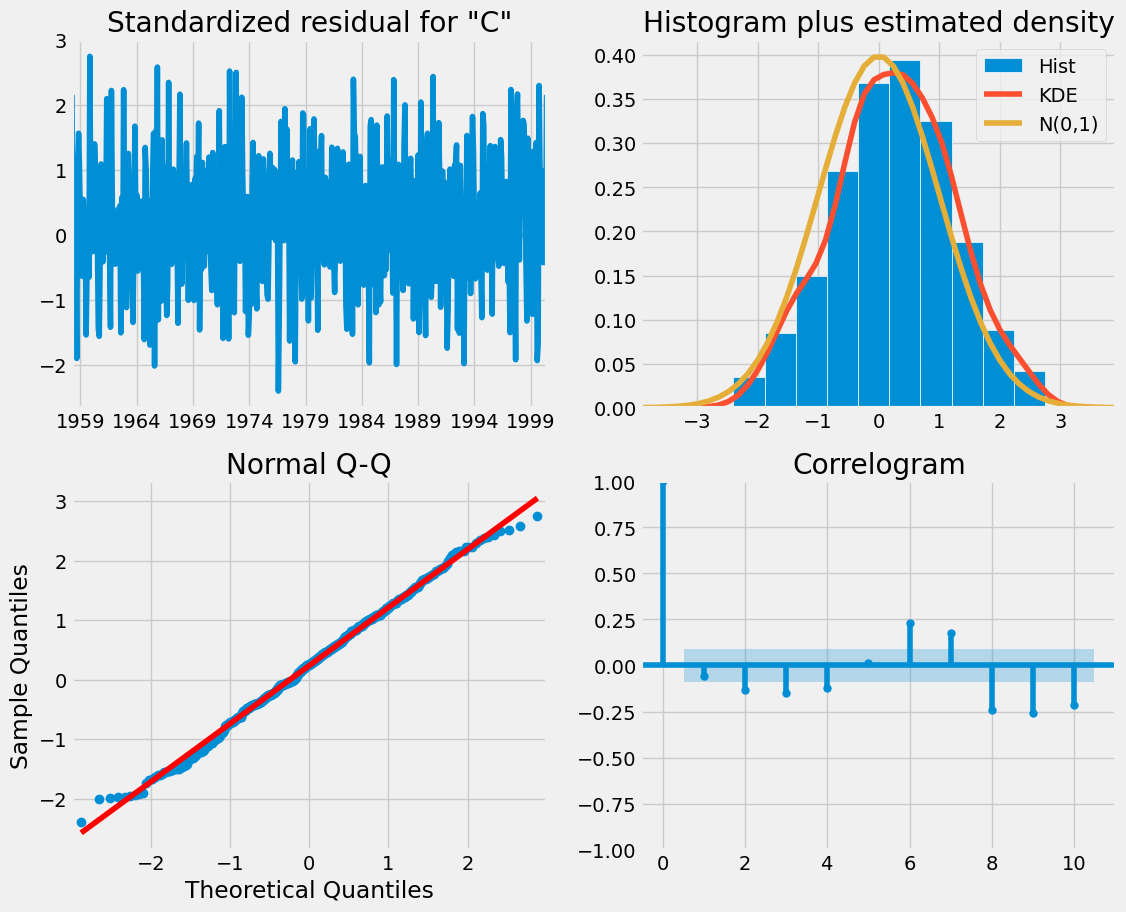

In [31]:
fitted.plot_diagnostics(figsize=(12,10));

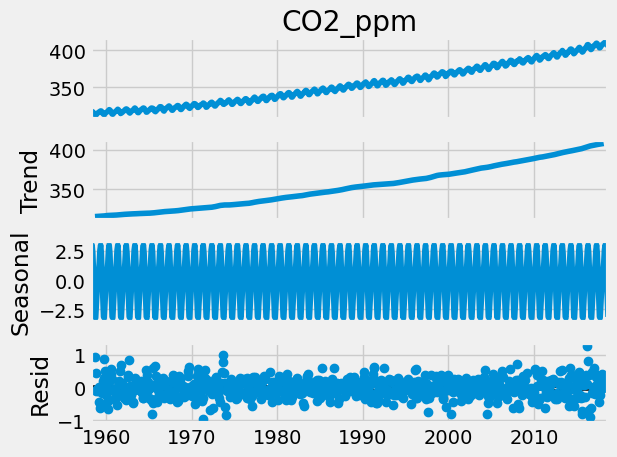

In [32]:
decom_results = seasonal_decompose(co['CO2_ppm'], period=12)
decom_results.plot()
plt.show()

In [33]:
sarima = SARIMAX(train[['CO2_ppm']], order=(3,1,9), seasonal_order=(3,1,9,12))
sarima_fitted = sarima.fit()

In [34]:
co2['sarimapred'] = sarima_fitted.predict(start=test.index[0], end=test.index[-1])

In [35]:
forecasts = sarima_fitted.get_forecast(12)
type(forecasts)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

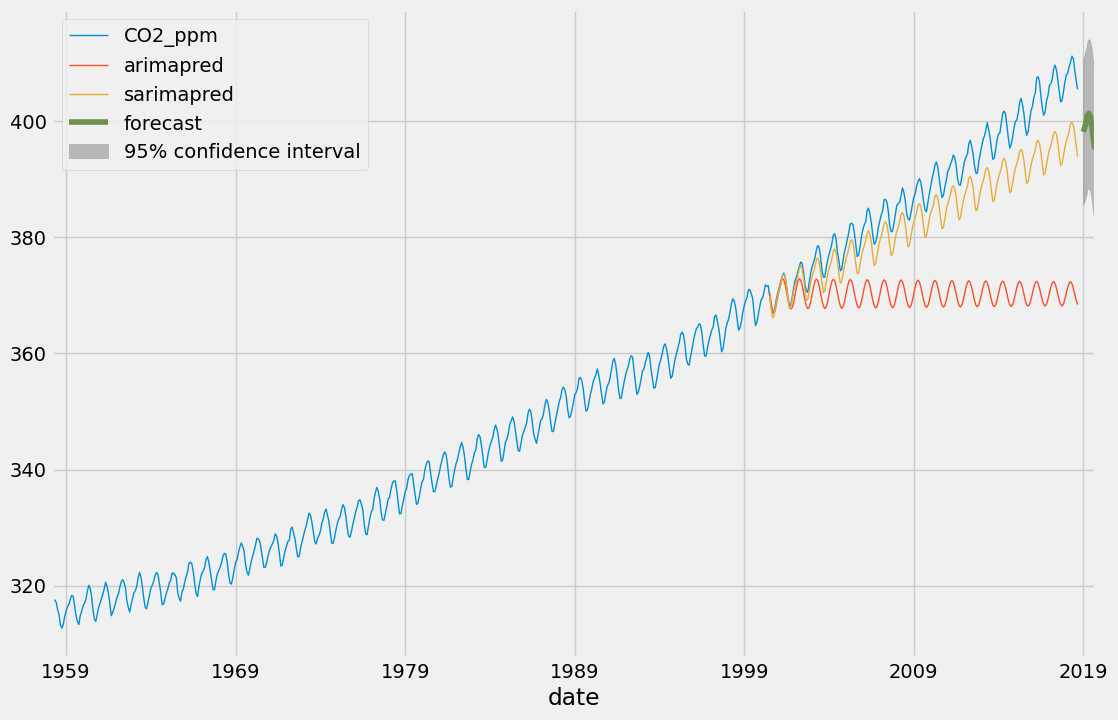

In [36]:
ax = co2['CO2_ppm'].plot(linewidth=1, figsize=(12,8))
co2['arimapred'].plot(linewidth=1, ax=ax)
co2['sarimapred'].plot(linewidth=1, ax=ax)
plot_predict(sarima_fitted, start='2019-01-01', end='2019-10-01', ax=ax)
plt.legend()
plt.show()

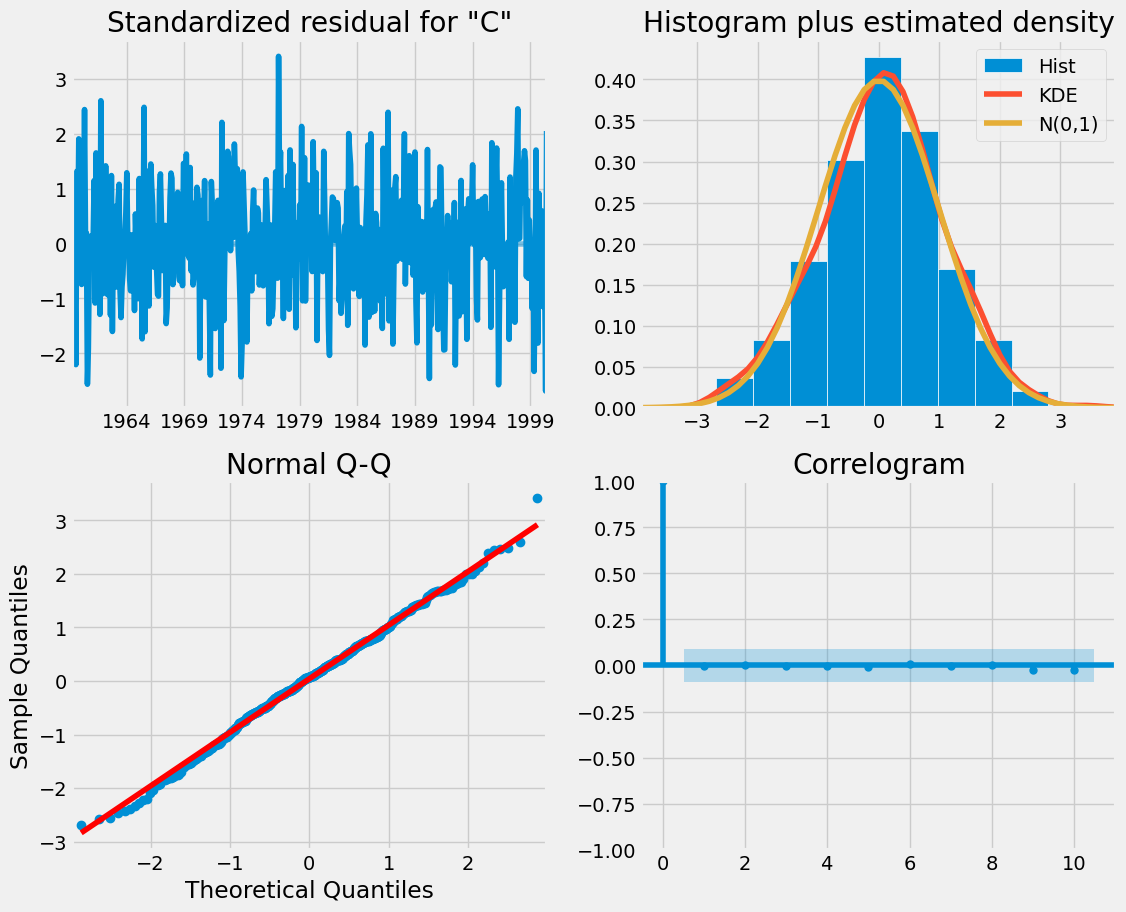

In [37]:
sarima_fitted.plot_diagnostics(figsize=(12,10));

In [38]:
sarima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            CO2_ppm   No. Observations:                  508
Model:             SARIMAX(3, 1, 9)x(3, 1, 9, 12)   Log Likelihood                -107.340
Date:                            Tue, 07 Jan 2025   AIC                            264.681
Time:                                    19:58:46   BIC                            369.795
Sample:                                03-01-1958   HQIC                           305.945
                                     - 06-01-2000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3639      0.295     -1.235      0.217      -0.942       0.214
ar.L2         -0.2807      0.270     -1.041      0.298      -0.809       0.248
ar.L3         -0.5480      0.269     -2.040      0.041      -1.074      -0.022
ma.L1          0.0017      0.291      0.006      0.995      -0.569       0.573
ma.L2          0.1034      0.262      0.395      0.693      -0.409       0.616
ma.L3          0.3991      0.260      1.536      0.125      -0.110       0.909
ma.L4         -0.2596      0.115     -2.253      0.024      -0.485      -0.034
ma.L5          0.0466      0.055      0.842      0.400      -0.062       0.155
ma.L6         -0.0669      0.072     -0.930      0.352      -0.208       0.074
ma.L7         -0.0183      0.067     -0.273      0.785      -0.149       0.113
ma.L8          0.0319      0.066      0.483      0.629      -0.098       0.162
ma.L9          0.0792      0.064      1.237      0.216      -0.046       0.205
ar.S.L12      -0.1872      0.650     -0.288      0.773      -1.461       1.087
ar.S.L24       0.1762      0.456      0.387      0.699      -0.717       1.070
ar.S.L36      -0.4984      0.481     -1.036      0.300      -1.441       0.445
ma.S.L12      -0.6388      0.657     -0.972      0.331      -1.927       0.649
ma.S.L24      -0.4266      0.485     -0.880      0.379      -1.376       0.523
ma.S.L36       0.7183      0.687      1.046      0.296      -0.628       2.065
ma.S.L48      -0.4497      0.451     -0.997      0.319      -1.334       0.435
ma.S.L60      -0.1181      0.080     -1.482      0.138      -0.274       0.038
ma.S.L72       0.0978      0.100      0.976      0.329      -0.099       0.294
ma.S.L84       0.0221      0.081      0.272      0.785      -0.137       0.181
ma.S.L96      -0.0432      0.091     -0.476      0.634      -0.221       0.135
ma.S.L108      0.1186      0.079      1.505      0.132      -0.036       0.273
sigma2         0.0860      0.007     12.696      0.000       0.073       0.099
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.94   Prob(JB):                         0.80
Heteroskedasticity (H):               1.04   Skew:                            -0.07
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""